# Projet Métaheuristique : Cluster First - Route Second
http://dimacs.rutgers.edu/programs/challenge/vrp/cvrp/<br>
http://vrp.galgos.inf.puc-rio.br/index.php/en/plotted-instances?data=X-n101-k25<br>
http://dimacs.rutgers.edu/files/6916/3848/0327/CVRP_Competition_Rules.pdf<br>
https://www.cirrelt.ca/documentstravail/cirrelt-2011-12.pdf<br>
https://www.jstor.org/stable/pdf/4102067.pdf?refreqid=excelsior%3Ac082c879db7df12627f560be34e84feb&ab_segments=&origin=

### Rappels des objectifs du projet :  
+ Comprendre le problème CVRP
+ Comprendre le format des jeux de données
+ Construire et développer une heuristique (construire = méthode gloutonne) pour obtenir
une solution réalisable.
+ Concevoir et développer une méthode de recherche locale (recherche de voisins)
    - méthode de descente (intensification)
    - méthode avec diversification (tabou...)


# 1ère étape) Compréhension du problème CVRP

## Introduction  

L'objectif de ce projet est d'implémenter des méthodes approchées permettant de résoudre un problème de planification de tournées de véhicules.  
Il s'ait des problèmes CVRP : *Capacited Vehicle Routing Problem*.  

Notre entreprise de livraison dispose d'un ensemble de camions avec une capacité limité.  
Nous avons un ensemble de clients à desservir en partant d'un point de départ : le dépôt de notre entreprise de livraison. Nous connaissons la localisation de chacun des clients dans la section *NODE_COORD_SECTION* du fichire vrp.  Chaque demande d'un client représente une quantité qu'il faut livrer du dépôt à la localisation du client.  
Le but est donc de déterminer les tournées pour les véhicules afin de minimiser la somme des distances parcourrues (temps de transport).  
Il est nécessaire de respecter :  
+ la contrainte de capacité des camions  
+ la contrainte qui impose de satisfaire tous les clients


Nous partons de l'algorithme de clustering KMeans qui va proposer une solution initiale de nos tournées en considérant que l'on a 1 camion par Cluster.

## Chargement des instances sur le site du challenge DIMACS (CVRPLIB)
Le site du challenge DIMACS nous procure des intances de différentes tailles afin d'évaluer nos méthode de résolution.  
Par exemple l'instance **X-n101-k25** signifie qu'il y a 100 clients, le nombre minimum de véhicules permettant d'avoir une solution est 25 (mais on peut en prendre davantage), la demande de chaque client est comprise entre 0 et 100 (en quantité).  
Le site permet de visualiser directement une solution.

In [1]:
Instance = "X-n101-k25"
Instance = "X-n120-k6"
!wget -c http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances//X/{Instance}.sol
!wget -c http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances//X/{Instance}.vrp
!wget -c http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances//X/X-n120-k6.vrp
!wget -c http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances//X/X-n120-k6.sol 

--2022-03-24 15:42:24--  http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances//X/X-n120-k6.sol
Resolving vrp.galgos.inf.puc-rio.br... 139.82.16.196
Connecting to vrp.galgos.inf.puc-rio.br|139.82.16.196|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2022-03-24 15:42:25--  http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances//X/X-n120-k6.vrp
Resolving vrp.galgos.inf.puc-rio.br... 139.82.16.196
Connecting to vrp.galgos.inf.puc-rio.br|139.82.16.196|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2022-03-24 15:42:26--  http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances//X/X-n120-k6.vrp
Resolving vrp.galgos.inf.puc-rio.br... 139.82.16.196
Connecting to vrp.galgos.inf.puc-rio.br|139.82.16.196|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
problem = open(Instance+".vrp", "r")
print(problem.read(398))

NAME : 	X-n120-k6	
COMMENT : 	"Generated by Uchoa, Pecin, Pessoa, Poggi, Subramanian, and Vidal (2013)"	
TYPE : 	CVRP	
DIMENSION : 	120	
EDGE_WEIGHT_TYPE : 	EUC_2D	
CAPACITY : 	21	
NODE_COORD_SECTION		
1	0	0
2	927	318
3	319	475
4	471	281
5	894	615
6	712	832
7	677	210
8	336	967
9	490	360
10	367	685
11	153	169
12	799	63
13	247	455
14	492	585
15	131	701
16	309	721
17	210	256
18	511	753
19	447	796
2


In [3]:
# The input files follow the "Augerat" format.
import math
import sys
def read_input_cvrp(filename):
    file_it = iter(read_elem(filename))
    nb_trucks = get_nb_trucks(filename)
    nb_nodes = 0
    while (1):
        token = next(file_it)
        if token == "DIMENSION":
            next(file_it)  # Removes the ":"
            nb_nodes = int(next(file_it))
            nb_customers = nb_nodes - 1
        elif token == "CAPACITY":
            next(file_it)  # Removes the ":"
            truck_capacity = int(next(file_it))
        elif token == "EDGE_WEIGHT_TYPE":
            next(file_it)  # Removes the ":"
            token = next(file_it)
            if token != "EUC_2D":
                print("Edge Weight Type " + token + " is not supported (only EUD_2D)")
                sys.exit(1)
        elif token == "NODE_COORD_SECTION":
            break

    customers_x = [None] * nb_customers
    customers_y = [None] * nb_customers
    depot_x = 0
    depot_y = 0
    for n in range(nb_nodes):
        node_id = int(next(file_it))
        if node_id != n + 1:
            print("Unexpected index")
            sys.exit(1)
        if node_id == 1:
            depot_x = int(next(file_it))
            depot_y = int(next(file_it))
        else:
            # -2 because orginal customer indices are in 2..nbNodes
            customers_x[node_id - 2] = int(next(file_it))
            customers_y[node_id - 2] = int(next(file_it))

    # Compute distance matrix
    distance_matrix = compute_distance_matrix(customers_x, customers_y)
    distance_warehouses = compute_distance_warehouses(depot_x, depot_y, customers_x, customers_y)

    token = next(file_it)
    if token != "DEMAND_SECTION":
        print("Expected token DEMAND_SECTION")
        sys.exit(1)

    demands = [None] * nb_customers
    for n in range(nb_nodes):
        node_id = int(next(file_it))
        if node_id != n + 1:
            print("Unexpected index")
            sys.exit(1)
        if node_id == 1:
            if int(next(file_it)) != 0:
                print("Demand for depot should be 0")
                sys.exit(1)
        else:
            # -2 because orginal customer indices are in 2..nbNodes
            demands[node_id - 2] = int(next(file_it))

    token = next(file_it)
    if token != "DEPOT_SECTION":
        print("Expected token DEPOT_SECTION")
        sys.exit(1)

    warehouse_id = int(next(file_it))
    if warehouse_id != 1:
        print("Warehouse id is supposed to be 1")
        sys.exit(1)

    end_of_depot_section = int(next(file_it))
    if end_of_depot_section != -1:
        print("Expecting only one warehouse, more than one found")
        sys.exit(1)
    return (nb_customers, customers_x, customers_y, nb_trucks, truck_capacity, distance_matrix, depot_x, depot_y, distance_warehouses, demands)

def read_elem(filename):
    with open(filename) as f:
        return [str(elem) for elem in f.read().split()]

# Computes the distance matrix
def compute_distance_matrix(customers_x, customers_y):
    nb_customers = len(customers_x)
    distance_matrix = [[None for i in range(nb_customers)] for j in range(nb_customers)]
    for i in range(nb_customers):
        distance_matrix[i][i] = 0
        for j in range(nb_customers):
            dist = compute_dist(customers_x[i], customers_x[j], customers_y[i], customers_y[j])
            distance_matrix[i][j] = dist
            distance_matrix[j][i] = dist
    return distance_matrix


# Computes the distances to warehouse
def compute_distance_warehouses(depot_x, depot_y, customers_x, customers_y):
    nb_customers = len(customers_x)
    distance_warehouses = [None] * nb_customers
    for i in range(nb_customers):
        dist = compute_dist(depot_x, customers_x[i], depot_y, customers_y[i])
        distance_warehouses[i] = dist
    return distance_warehouses


def compute_dist(xi, xj, yi, yj):
    exact_dist = math.sqrt(math.pow(xi - xj, 2) + math.pow(yi - yj, 2))
    return int(math.floor(exact_dist + 0.5))


def get_nb_trucks(filename):
    begin = filename.rfind("-k")
    if begin != -1:
        begin += 2
        end = filename.find(".", begin)
        return int(filename[begin:end])
    print("Error: nb_trucks could not be read from the file name. Enter it from the command line")
    sys.exit(1)

In [4]:
nb_customers, customers_x, customers_y, nb_trucks, truck_capacity, distance_matrix, depot_x, depot_y, distance_warehouses, demands = read_input_cvrp(Instance+".vrp")
print("-- CUSTOMERS --")
print("There are",nb_customers,"customers")
print("- X position of the customers is size",np.array(customers_x).shape)
print("- Y position of the customers is size",np.array(customers_y).shape)
print("The demand of each client are is size",len(demands))
print("The distance matrix is size (euclidian distances between customer_x and customers_y)",np.array(distance_matrix).shape)
print("-- TRUCKS --")
print("There are at least",nb_trucks,"trucks")
print("The truck capacity is",truck_capacity)
print("-- WAREHOUSES --")
print("- X position of the warehouse",depot_x)
print("- Y position of the warehouse",depot_y)
print("The distance of each client to the warehouses are (euclidian distance between customer_x and warehouse) is size",len(distance_warehouses))

-- CUSTOMERS --
There are 119 customers
- X position of the customers is size (119,)
- Y position of the customers is size (119,)
The demand of each client are is size 119
The distance matrix is size (euclidian distances between customer_x and customers_y) (119, 119)
-- TRUCKS --
There are at least 6 trucks
The truck capacity is 21
-- WAREHOUSES --
- X position of the warehouse 0
- Y position of the warehouse 0
The distance of each client to the warehouses are (euclidian distance between customer_x and warehouse) is size 119


# Visualisation de notre instance : clients + dépôt

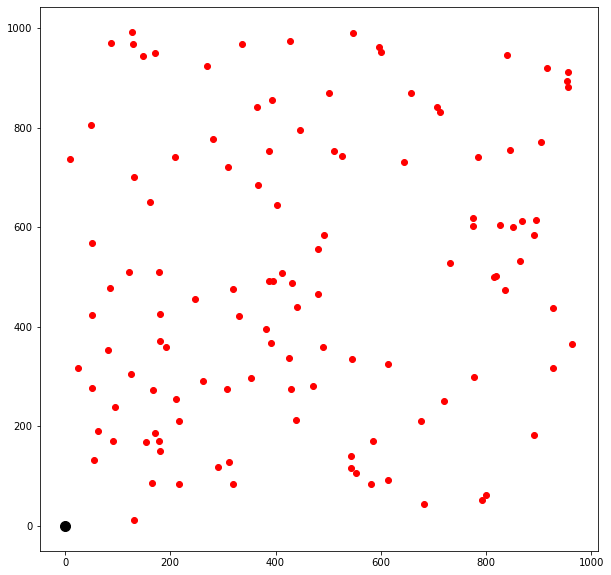

In [5]:
plt.figure(figsize=(10,10))
plt.scatter(customers_x,customers_y,c="r")
plt.scatter(depot_x,depot_y,c="black",s=100)
plt.show()

In [6]:
def get_route_cost(route):
    total_cost = 0
    # Trajets jusqu'au dépôt
    x_values = [depot_x, customers_x[route[0]]]
    y_values = [depot_y, customers_y[route[0]]]
    total_cost += compute_dist(x_values[0],x_values[1],y_values[0],y_values[1])
    x_values = [depot_x, customers_x[route[-1]]]
    y_values = [depot_y, customers_y[route[-1]]]
    total_cost += compute_dist(x_values[0],x_values[1],y_values[0],y_values[1])
    # Trajet entre clients
    for nb_customer in range(len(route)-1):
        x_values = [customers_x[route[nb_customer]], customers_x[route[nb_customer+1]]]
        y_values = [customers_y[route[nb_customer]], customers_y[route[nb_customer+1]]]
        total_cost += compute_dist(x_values[0],x_values[1],y_values[0],y_values[1])
    return total_cost

def get_route_capacity(route):
    total_capacity= 0
    # Trajet entre clients
    for customer in route:
        total_capacity += demands[customer]
    return total_capacity

def get_closest_from_warehouse(customers_list):
    closest_customer = customers_list[0]
    for customer in customers_list:
        if distance_warehouses[customer]<distance_warehouses[closest_customer]:
            closest_customer = customer
        if distance_warehouses[customer]<distance_warehouses[closest_customer]:
            closest_customer = max(customer,closest_customer)
    return closest_customer

def get_closest_customer(current_customer,customers_list):
    closest_customer = customers_list[0] # Initialisation
    for new_customer in customers_list:
        smallest_distance = compute_dist(customers_x[current_customer],customers_x[closest_customer],customers_y[current_customer],customers_y[closest_customer]) 
        customer_distance = compute_dist(customers_x[current_customer],customers_x[new_customer],customers_y[current_customer],customers_y[new_customer]) 
        if customer_distance < smallest_distance:
            closest_customer = new_customer
        if customer_distance == smallest_distance:
            closest_customer = max(new_customer,closest_customer)
    return closest_customer

import random
def create_routes(custom_truck_capacity, initialization = 1):
    customers_list = list(np.arange(0,nb_customers,1)) # Initialisation
    random.shuffle(customers_list) # Aucun impact sur les performances
    routes = []
    while (len(customers_list)!=0):
        # print("Liste à dispatcher :",customers_list)
        route=[]
        if initialization==1:
            closest_customer = get_closest_from_warehouse(customers_list) # Initialisation
        if initialization==2:
            closest_customer = random.choice(customers_list) # Initialisation
        route_capacity = 0
        while (route_capacity + demands[closest_customer] <= custom_truck_capacity) and (len(customers_list)!=0):
            route.append(closest_customer)
            route_capacity = sum([demands[customer] for customer in route])
            customers_list.remove(closest_customer)
            if len(customers_list) > 0:
                closest_customer = get_closest_customer(route[-1],customers_list)
        routes.append(route)
        # print("Route:",route)
        # print("Demande:",route_capacity)
        # print("-------")
    return routes

def display_routes(routes):
    df = pd.DataFrame(columns=["customers_x","customers_y","demands","route"])
    route_number = 0
    iterator = 0
    for route in routes:
        for customer in route:
            new_line = np.array([customers_x[customer],customers_y[customer],demands[customer],route_number])
            df.loc[iterator]=new_line
            iterator += 1
        route_number += 1
        
    cmap = plt.get_cmap('jet', len(routes))
    cmap.set_under('gray')
    fig = plt.figure(figsize=(15,15))
    renderer = fig.canvas.get_renderer()
    for customer in range(nb_customers):
        plt.annotate(str(customer),[customers_x[customer],customers_y[customer]], )
        
    # Clients
    plt.scatter(df["customers_x"],df["customers_y"],c=df["route"],cmap=cmap,s=300)
    plt.colorbar()

    # Dépot
    plt.scatter(depot_x,depot_y,c="black",s=1000,marker='s')

    # Routes
    for route in routes:
        
        # Trajets jusqu'au dépôt
        x_values = [depot_x, customers_x[route[0]]]
        y_values = [depot_y, customers_y[route[0]]]
        plt.plot(x_values, y_values, marker="None", linestyle="--", c="lightgray")
        x_values = [depot_x, customers_x[route[-1]]]
        y_values = [depot_y, customers_y[route[-1]]]
        plt.plot(x_values, y_values, marker="None", linestyle="--", c="lightgray")
        
        
        # Trajet entre clients
        for nb_customer in range(len(route)-1):
            x_values = [customers_x[route[nb_customer]], customers_x[route[nb_customer+1]]]
            y_values = [customers_y[route[nb_customer]], customers_y[route[nb_customer+1]]]
            plt.plot(x_values, y_values, marker="None", linestyle="-", c="black")
    plt.axis('scaled')

    plt.show()
    return df

## Initialisation Kmeans de la proximité des clients

In [7]:
nb_clusters = nb_trucks

In [8]:
# coords = np.array(coords).reshape(nb_customers,2)
df = pd.DataFrame()
df["customers_x"] = customers_x
df["customers_y"] = customers_y
display(df.head())
print(df.shape)

,customers_x,customers_y
0,927,318
1,319,475
2,471,281
3,894,615
4,712,832


(119, 2)


In [9]:
from sklearn.cluster import KMeans
km = KMeans(
     init="k-means++",
     n_clusters=nb_clusters,
     n_init=100,
     max_iter=600,
     random_state=42
)
km.fit(df)
clusters = km.labels_
centroids = km.cluster_centers_

In [10]:
print(clusters)

[0 3 3 0 5 4 1 3 1 2 4 3 3 1 1 2 5 1 1 2 2 0 1 0 2 5 4 1 2 2 2 2 1 4 4 1 0
 2 3 4 5 3 3 1 3 5 5 1 3 2 5 2 0 2 2 4 0 1 0 0 2 4 5 3 1 5 2 0 0 3 2 4 2 1
 5 3 0 3 3 2 0 3 1 2 5 1 4 2 5 4 2 4 2 2 0 2 1 3 3 0 5 4 5 5 5 1 2 5 3 1 4
 3 3 3 1 2 5 2 2]


In [11]:
print(centroids)

[[851.2        526.46666667]
 [231.28571429 824.76190476]
 [161.4137931  243.17241379]
 [405.72727273 427.09090909]
 [669.64285714 152.92857143]
 [731.05555556 853.27777778]]


In [12]:
clusters_dict = {}
for i in range (nb_customers):
    clusters_dict[str(i)] = clusters[i]
df["demands"] = demands
df["cluster"] = list(clusters_dict.values())
df["centroid_x"] = centroids[df["cluster"]][:,0]
df["centroid_y"] = centroids[df["cluster"]][:,1]
df.head()

,customers_x,customers_y,demands,cluster,centroid_x,centroid_y
0,927,318,1,0,851.200000,526.466667
1,319,475,1,3,405.727273,427.090909
2,471,281,1,3,405.727273,427.090909
3,894,615,1,0,851.200000,526.466667
4,712,832,1,5,731.055556,853.277778


In [13]:
km.labels_

array([0, 3, 3, 0, 5, 4, 1, 3, 1, 2, 4, 3, 3, 1, 1, 2, 5, 1, 1, 2, 2, 0,
       1, 0, 2, 5, 4, 1, 2, 2, 2, 2, 1, 4, 4, 1, 0, 2, 3, 4, 5, 3, 3, 1,
       3, 5, 5, 1, 3, 2, 5, 2, 0, 2, 2, 4, 0, 1, 0, 0, 2, 4, 5, 3, 1, 5,
       2, 0, 0, 3, 2, 4, 2, 1, 5, 3, 0, 3, 3, 2, 0, 3, 1, 2, 5, 1, 4, 2,
       5, 4, 2, 4, 2, 2, 0, 2, 1, 3, 3, 0, 5, 4, 5, 5, 5, 1, 2, 5, 3, 1,
       4, 3, 3, 3, 1, 2, 5, 2, 2])

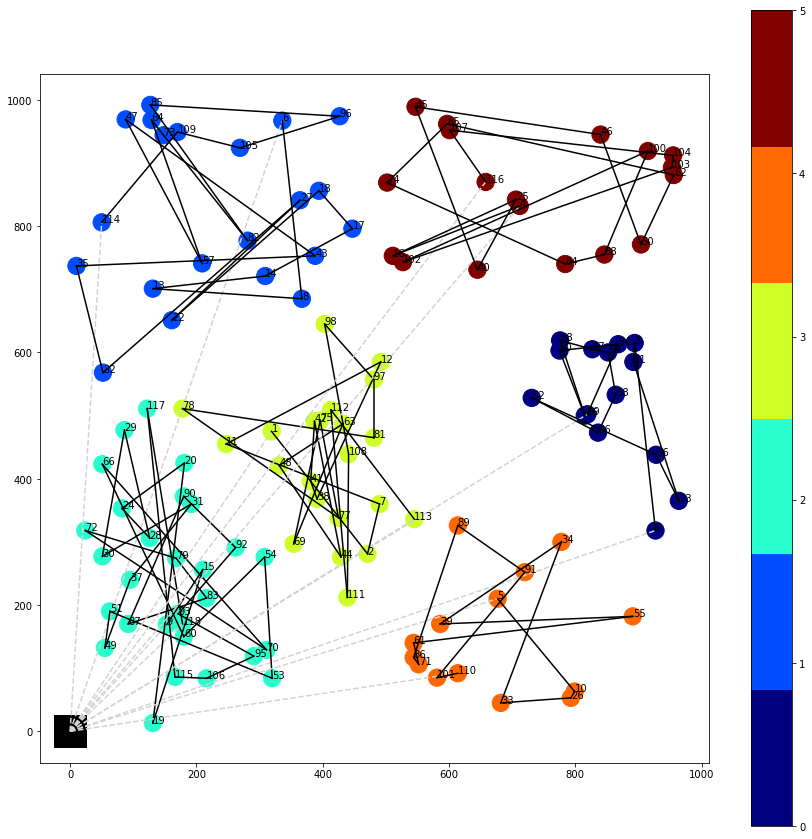

In [14]:
routes = []
for cluster in range (nb_clusters):
    route = []
    for customer in range(len(km.labels_)):
        if km.labels_[customer]==cluster:
            route.append(customer)
    routes.append(route)
df = display_routes(routes)

# 2ème étape) Implémentation et évaluation d'une heuristique
## Minimisations des routes
**Remarques :**  
On créé la liste des clients pour chaque cluster. Le code parcourt donc tous les clients à l'aide de la boucle `for i in range(nb_customers-1):`, grâce au dictionnaire `clusters_dict` précédemment créé, on peut facilement tester si le i-ème client a comme numéro de cluster le cluster de la première boucle for.  

La liste `routes` : liste de liste qui précise pour chaque cluster tous les identifiants de clients qu'il contient.

La liste `route` : liste simple des clients du i-ème cluster quand on parcourt la 1ere boucle for.  

La liste `clusters_demand` : contient la demande totale des clients pour chacun des clusters.

On convertit en un ensemble (set) pour supprimer les doublons :  
`alright = list(set(list(np.arange(0,len(clusters_demand),1))).difference(exceeding))`


In [15]:
routes = []
for cluster in range(0,nb_trucks):
    route=[]
    for i in range(nb_customers-1):
        if clusters_dict[str(i)]==cluster:
            route.append(i)
    routes.append(route)
print("Voici les regroupements de customers par clusters :")
print(routes)
clusters_demand=[]
for route in routes:
    route_demand=0
    for customer in route:
        route_demand+=demands[customer-1]
    clusters_demand.append(route_demand)
print("Voici la demande de chaque cluster :")
print(clusters_demand)
exceeding = [cluster for cluster in range(len(clusters_demand)) if clusters_demand[cluster] > truck_capacity]
alright = list(set(list(np.arange(0,len(clusters_demand),1))).difference(exceeding))
print("Voici la liste des clusters capacitaires :")
print(alright)
print("Voici la liste des clusters excédentaires :")
print(exceeding)

Voici les regroupements de customers par clusters :
[[0, 3, 21, 23, 36, 52, 56, 58, 59, 67, 68, 76, 80, 94, 99], [6, 8, 13, 14, 17, 18, 22, 27, 32, 35, 43, 47, 57, 64, 73, 82, 85, 96, 105, 109, 114], [9, 15, 19, 20, 24, 28, 29, 30, 31, 37, 49, 51, 53, 54, 60, 66, 70, 72, 79, 83, 87, 90, 92, 93, 95, 106, 115, 117], [1, 2, 7, 11, 12, 38, 41, 42, 44, 48, 63, 69, 75, 77, 78, 81, 97, 98, 108, 111, 112, 113], [5, 10, 26, 33, 34, 39, 55, 61, 71, 86, 89, 91, 101, 110], [4, 16, 25, 40, 45, 46, 50, 62, 65, 74, 84, 88, 100, 102, 103, 104, 107, 116]]
Voici la demande de chaque cluster :
[15, 21, 28, 22, 14, 18]
Voici la liste des clusters capacitaires :
[0, 1, 4, 5]
Voici la liste des clusters excédentaires :
[2, 3]


**Remarque :**  
Ici nous avons une méthode initiale avec une solution que l'on considère admissible, mais elle ne respecte pas la contrainte de capacité des camions pour tous les clusters. Cette pour cette raison que dans la suite du notebook nous implémentons une *méthode dîtes de Descente* qui va améliorer petit à petit notre solution en prenant en compte les camions et en dispatchant les clients excédentaires.

# 3ème étape) Implémentation et évaluation d'une métaheuristique basée sur la recherche locale
Ce type de méthode basée sur la recherche locale nécessite de parcourir des voisinages de solutions afin d'aboutir à une solution ayant une meilleure valeur de la fonction objectif.  
+ définir les voisinages considérés  
+ définir la stratégie d'exploration du ou des voisinages

## Méthode de Descente : dispatch des clients excédentaires
Cette boucle while a pour but de répartir chaque client excédentaire vers le cluster ayant le centroïd le plus proche. 

**Principe de notre méthode Heuristique :**   
Le but est d'attribuer les clients excédentaires au cluster ayant le centroide le plus proche  
- Regarder les distances des centroids entre Clusters car si la demande d'un client dans le cluster i fait dépasser la capacité du camion i, alors il faudra attribuer ce client dans le cluster le plus proche j afin que le camion j gère ce client problématique.  
- Ajouter la prise en compte de la contrainte de capacité des camions et tester si la demande totale des clients de ce cluster dépasse la capacité du cluster


In [16]:
timeout=0
# while len(exceeding)>0 :
while True:
    if timeout == 1000:
        print("Timed out")
        break
    timeout+=1
    # print("--- Itération",timeout,"---")
    if len(exceeding)>0:
        for exceeding_cluster in exceeding:
            clients_a_dispatcher = [int(list(clusters_dict.keys())[i]) for i in range(len(clusters_dict)) if clusters_dict[list(clusters_dict.keys())[i]]==exceeding_cluster] # Récupérer la liste des customers appartenant au cluster "exceeding_cluster"
            closest_distances = []
            closest_customers = []
            closest_centroid = []
            for alright_cluster in alright:
                distances_clients_centroid_le_plus_proche = []
                for client in clients_a_dispatcher:
                    distances_clients_centroid_le_plus_proche.append(compute_dist(centroids[alright_cluster][0],customers_x[client],centroids[alright_cluster][1],customers_y[client]))
                zipped_lists = zip(distances_clients_centroid_le_plus_proche, clients_a_dispatcher)
                sorted_zipped_lists = sorted(zipped_lists)
                sorted_list = [element for _, element in sorted_zipped_lists]
                closest_distances.append(sorted_zipped_lists[0][0])
                closest_customers.append(sorted_zipped_lists[0][1])
                closest_centroid.append(alright_cluster)
            zipped_lists = zip(closest_distances, closest_customers, closest_centroid)
            sorted_zipped_lists = sorted(zipped_lists)
            for i in range(len(alright)):
                possibilité = sorted_zipped_lists[i]
                demande_surplus = df["demands"][possibilité[1]]
                #### Déplacement du customer du cluster excédent vers le cluster capacitaire le plus proche
                if clusters_demand[possibilité[2]] + demande_surplus < truck_capacity:
                    # print("Solution : Il faut donner le client",possibilité[1],"au cluster",possibilité[2],"à la distance",possibilité[0])
                    clusters_dict[str(possibilité[1])] = possibilité[2]
                else:
                    continue
                
            #### Mise à jour des clusters excédents ou capacitaire selon le changement qui vient d'être effectué
            routes = []
            for cluster in range(0,nb_trucks):
                route=[]
                for i in range(nb_customers-1):
                    if clusters_dict[str(i)]==cluster:
                        route.append(i)
                routes.append(route)
            clusters_demand=[]
            for route in routes:
                route_demand=0
                for customer in route:
                    route_demand+=demands[customer-1]
                clusters_demand.append(route_demand)
            exceeding = [cluster for cluster in range(len(clusters_demand)) if clusters_demand[cluster] > truck_capacity]
            alright = list(set(list(np.arange(0,len(clusters_demand),1))).difference(exceeding))
    else:
        print("Vous êtes arrivés au bout en ",timeout," iterations")
        break

Vous êtes arrivés au bout en  4  iterations


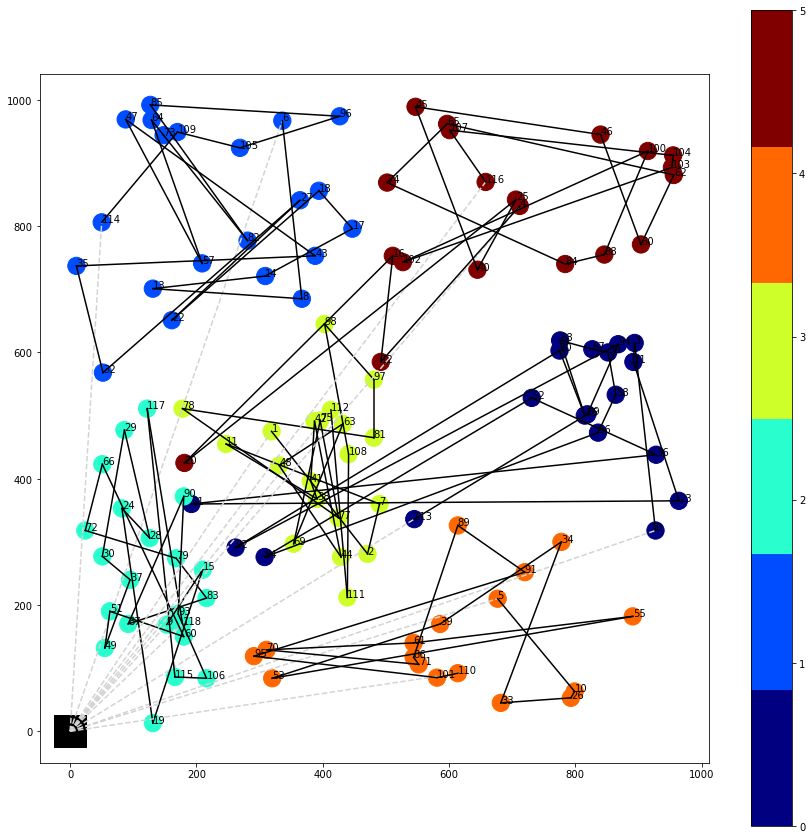

In [17]:
df["cluster"] = list(clusters_dict.values())
routes = []
for cluster in range (nb_clusters):
    route = []
    for customer in range(len(list(clusters_dict.values()))):
        if list(clusters_dict.values())[customer]==cluster:
            route.append(customer)
    routes.append(route)
_ = display_routes(routes)

# Optimisatin locale

In [18]:
def reorder_route_v1(route):
    if len(route)>2:
        customers_left = route.copy()
        # print("Route de base :",customers_left)
        
        best_route = [get_closest_from_warehouse(customers_left)]
        # print("Route begins by customer :",best_route[0])
        customers_left.remove(best_route[0])
        
        route_end = get_closest_from_warehouse(customers_left)
        # print("Route ends by customer :",route_end)
        customers_left.remove(route_end)
                
        while len(customers_left)>0:
            closest_customer = customers_left[0]
            closest_distance = compute_dist(customers_x[customers_left[0]],customers_x[best_route[-1]],customers_y[customers_left[0]],customers_y[best_route[-1]])
            # print("----")
            # print("Reste à dispatcher:",customers_left)
            for customer in customers_left:
                new_dist = compute_dist(customers_x[customer],customers_x[best_route[-1]],customers_y[customer],customers_y[best_route[-1]])
                if new_dist < closest_distance :
                    closest_customer = customer
                    closest_distance = new_dist
            # print("Client suivant :",closest_customer)
            customers_left.remove(closest_customer)
            # print("Client restant :",customers_left)
            best_route.append(closest_customer)
            # print("Middle Route :",middle_route)
            
        best_route.append(route_end)
        return(best_route)
    else :
        return(route)

def reorder_route_v2(route):
    if len(route)>1:
        customers_left = route.copy()
        # print("Route de base :",customers_left)
        
        best_route = [get_closest_from_warehouse(customers_left)]
        # print("Route begins by customer :",best_route[0])
        customers_left.remove(best_route[0])
                
        while len(customers_left)>0:
            closest_customer = customers_left[0]
            closest_distance = compute_dist(customers_x[customers_left[0]],customers_x[best_route[-1]],customers_y[customers_left[0]],customers_y[best_route[-1]])
            # print("----")
            # print("Reste à dispatcher:",customers_left)
            for customer in customers_left:
                new_dist = compute_dist(customers_x[customer],customers_x[best_route[-1]],customers_y[customer],customers_y[best_route[-1]])
                if new_dist < closest_distance :
                    closest_customer = customer
                    closest_distance = new_dist
            # print("Client suivant :",closest_customer)
            customers_left.remove(closest_customer)
            # print("Client restant :",customers_left)
            best_route.append(closest_customer)
            # print("Middle Route :",middle_route)

        return(best_route)
    else :
        return(route)

## V1

Cost | Capacity for route 0 : 2744 | 19
Cost | Capacity for route 1 : 3052 | 21
Cost | Capacity for route 2 : 1883 | 22
Cost | Capacity for route 3 : 2607 | 20
Cost | Capacity for route 4 : 2299 | 17
Cost | Capacity for route 5 : 3522 | 20
Total cost =  16107
[[92, 54, 113, 52, 80, 68, 67, 59, 94, 3, 21, 58, 99, 76, 56, 36, 23, 0, 31], [32, 13, 57, 82, 14, 8, 43, 17, 18, 27, 105, 6, 96, 109, 73, 64, 85, 47, 114, 35, 22], [19, 115, 106, 60, 118, 93, 9, 87, 51, 37, 30, 72, 24, 28, 79, 15, 83, 90, 66, 29, 117, 49], [69, 44, 2, 77, 38, 41, 48, 1, 42, 75, 112, 63, 108, 81, 97, 98, 11, 78, 7, 111], [95, 70, 61, 86, 71, 101, 110, 33, 26, 10, 55, 34, 91, 5, 39, 89, 53], [20, 16, 102, 40, 4, 25, 116, 107, 65, 45, 74, 84, 88, 50, 62, 103, 104, 100, 46, 12]]


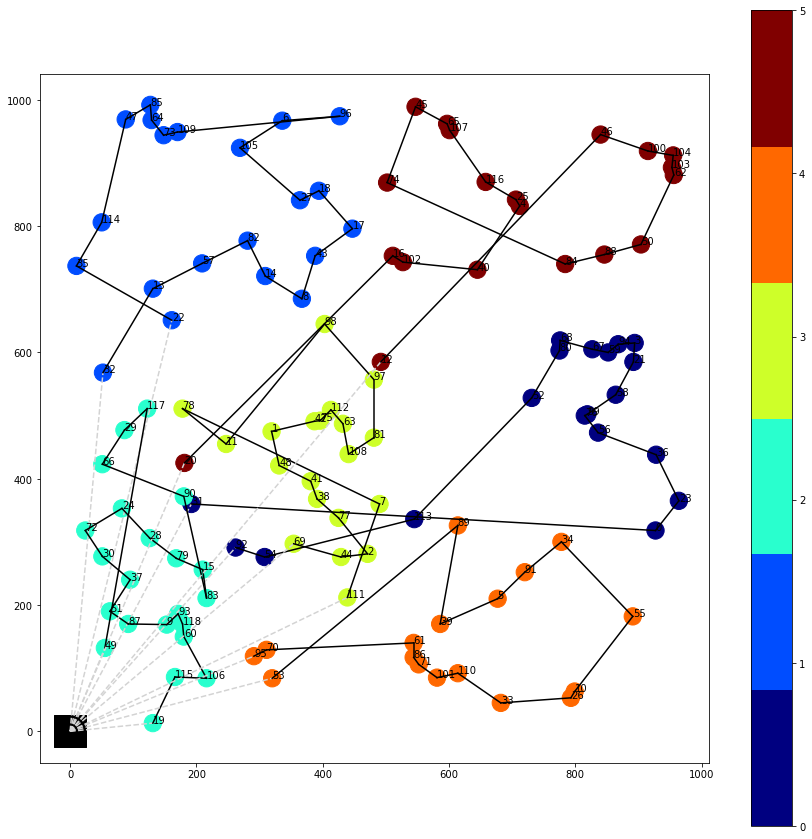

In [19]:
total_cost = 0
new_routes = []
for nb_route,route in enumerate(routes):
    best = reorder_route_v1(route)
    new_routes.append(best)
    print("Cost | Capacity for route {} : {} | {}".format(nb_route,get_route_cost(best),get_route_capacity(best)))
    total_cost+=get_route_cost(best)
print("Total cost = ",total_cost)
print(new_routes)
df = display_routes(new_routes)

## V2

Cost | Capacity for route 0 : 2833 | 19
Cost | Capacity for route 1 : 2984 | 21
Cost | Capacity for route 2 : 1883 | 22
Cost | Capacity for route 3 : 2607 | 20
Cost | Capacity for route 4 : 2333 | 17
Cost | Capacity for route 5 : 3252 | 20
Total cost =  15892
[[92, 54, 31, 113, 52, 80, 68, 67, 59, 94, 3, 21, 58, 99, 76, 56, 36, 23, 0], [32, 22, 13, 57, 82, 14, 8, 43, 17, 18, 27, 105, 6, 96, 109, 73, 64, 85, 47, 114, 35], [19, 115, 106, 60, 118, 93, 9, 87, 51, 37, 30, 72, 24, 28, 79, 15, 83, 90, 66, 29, 117, 49], [69, 44, 2, 77, 38, 41, 48, 1, 42, 75, 112, 63, 108, 81, 97, 98, 11, 78, 7, 111], [95, 70, 53, 86, 71, 61, 39, 110, 101, 33, 26, 10, 55, 34, 91, 5, 89], [20, 12, 102, 16, 74, 45, 65, 107, 116, 25, 4, 84, 88, 50, 62, 103, 104, 100, 46, 40]]


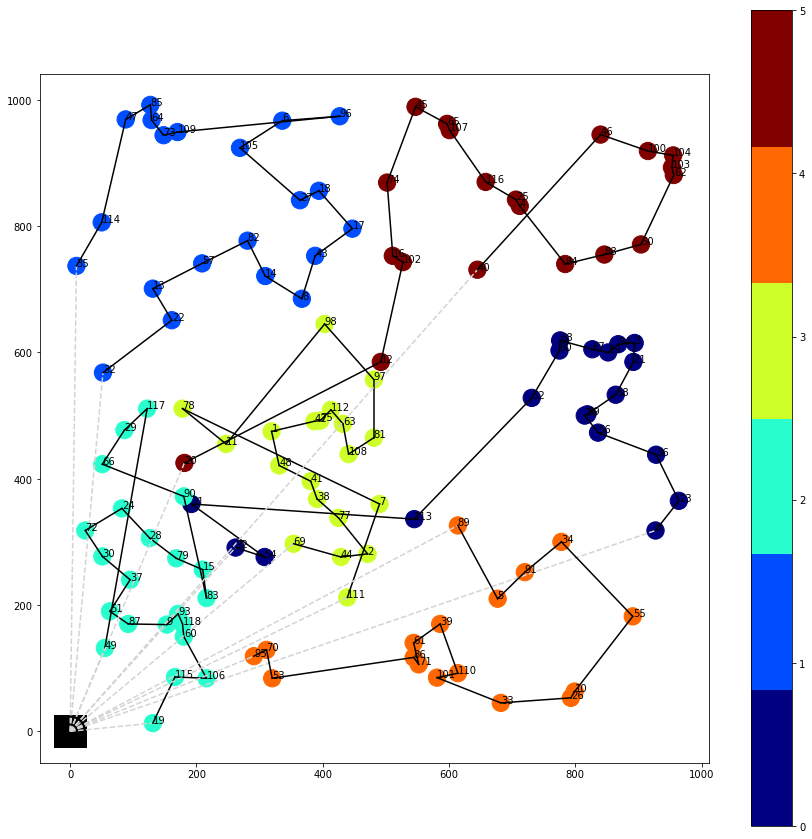

In [20]:
total_cost = 0
new_routes_v2 = []
for nb_route,route in enumerate(routes):
    best = reorder_route_v2(route)
    new_routes_v2.append(best)
    print("Cost | Capacity for route {} : {} | {}".format(nb_route,get_route_cost(best),get_route_capacity(best)))
    total_cost+=get_route_cost(best)
print("Total cost = ",total_cost)
print(new_routes_v2)
df = display_routes(new_routes_v2)

## Coefficient de Silhouette

**Remarque :**  
Il s'agit d'une métrique pour évaluer un partitionnement des données (*Clustering*). C'est une mesure de qualité d'un partitionnement d'un ensemble de données en classification automatique.  
Ce coefficient de Silhouette est compris entre -1 (pire classification) et +1 (meilleure classification).  
Pour chaque point, son coefficient de Silhouette est la différence entre la distance moyenne avec les points du même groupe que lui (cohésion) et la distance moyenne avec les points des autres groupes voisins (séparation). Si cette différence est *négative*, le point est en moyenne plus proche du groupe voisin que du sien : il est donc mal classé. À l'inverse, si cette différence est *positive*, le point est en moyenne plus proche de son groupe que du groupe voisin : il est donc bien classé.  

Le coefficient de Silhouette proprement dit est la moyenne du coefficient de Silhouette pour tous les points. 

For n_clusters = 6 The average silhouette_score is : 0.42624953179074226
For n_clusters = 7 The average silhouette_score is : 0.4259741959484052
For n_clusters = 8 The average silhouette_score is : 0.42491060790685853


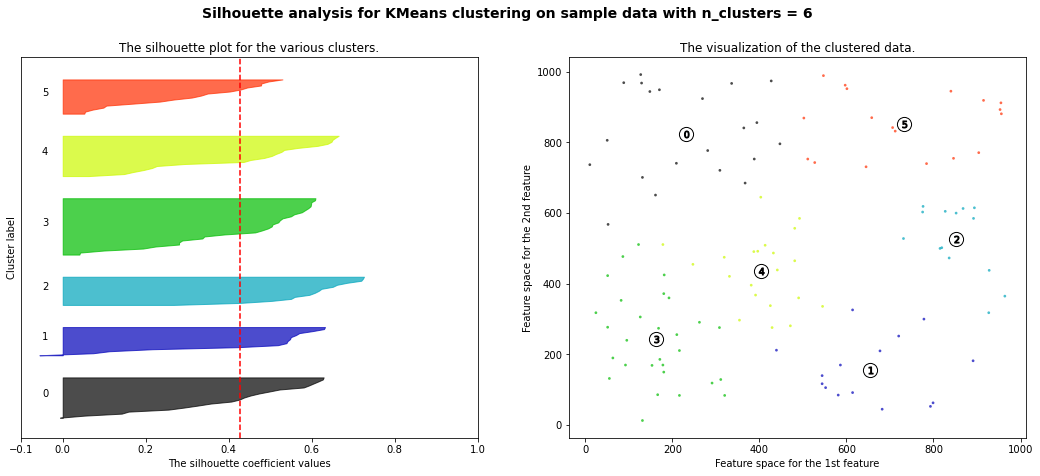

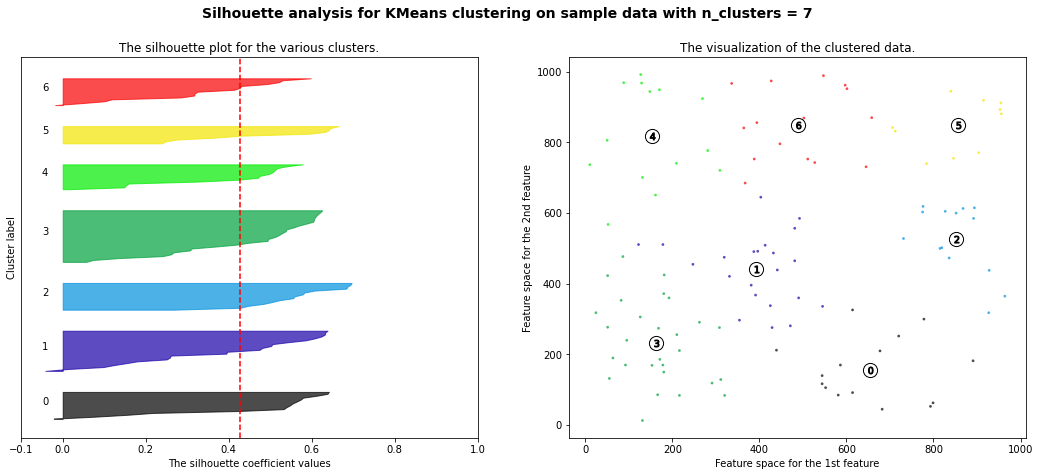

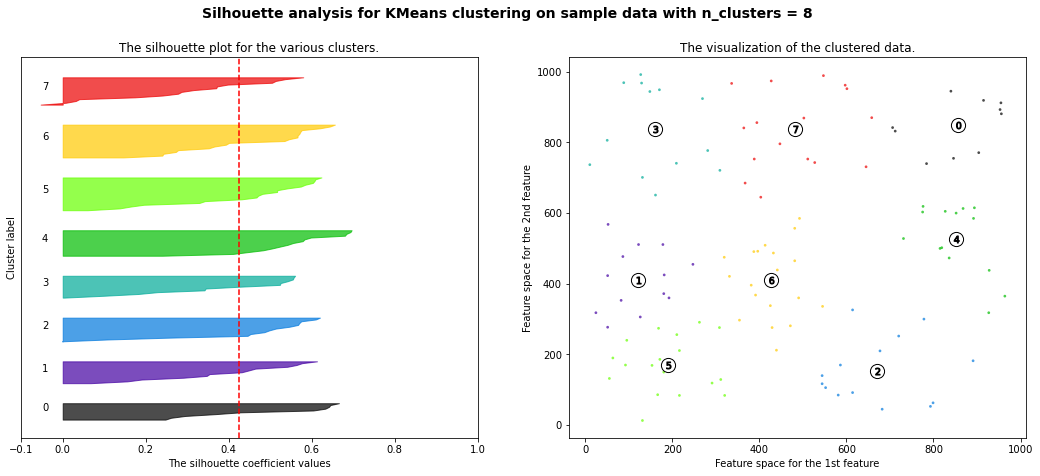

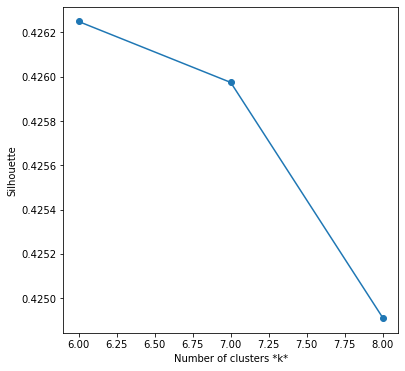

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

sse = []
list_k = list(range(nb_trucks, nb_trucks+3))
for n_clusters in list_k:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    sse.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        df["customers_x"], df["customers_y"], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
plt.show()
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Silhouette');